In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch.nn as nn

# Load training and test data from the dataset folder
train_data = pd.read_csv('../dataset/fashion-mnist_train.csv')
test_data = pd.read_csv('../dataset/fashion-mnist_test.csv')

# Separate labels and pixel values
X_train = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0  # Normalize pixel values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28) / 255.0
y_test = test_data.iloc[:, 0].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset for the full training data
full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the split ratio (e.g., 90% for training, 10% for validation)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

print("data is ready")


data is ready


In [2]:
# Confirm the sizes of train, validation, and test datasets
print("Train dataset size:", len(train_loader.dataset))
print("Validation dataset size:", len(val_loader.dataset))
print("Test dataset size:", len(test_loader.dataset))


Train dataset size: 54000
Validation dataset size: 6000
Test dataset size: 10000


In [3]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Dynamically flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Final output (logits)
        return x

model = CNNModel()

Epoch 1/10, Training Loss: 0.4861, Validation Loss: 0.3957, Validation Accuracy: 85.08%
Epoch 2/10, Training Loss: 0.3083, Validation Loss: 0.2781, Validation Accuracy: 89.88%
Epoch 3/10, Training Loss: 0.2604, Validation Loss: 0.2628, Validation Accuracy: 90.30%
Epoch 4/10, Training Loss: 0.2297, Validation Loss: 0.2519, Validation Accuracy: 90.75%
Epoch 5/10, Training Loss: 0.2082, Validation Loss: 0.2312, Validation Accuracy: 91.98%
Epoch 6/10, Training Loss: 0.1836, Validation Loss: 0.2270, Validation Accuracy: 91.67%
Epoch 7/10, Training Loss: 0.1659, Validation Loss: 0.2235, Validation Accuracy: 92.50%
Epoch 8/10, Training Loss: 0.1477, Validation Loss: 0.2348, Validation Accuracy: 91.78%
Epoch 9/10, Training Loss: 0.1300, Validation Loss: 0.2307, Validation Accuracy: 91.85%
Epoch 10/10, Training Loss: 0.1138, Validation Loss: 0.2295, Validation Accuracy: 92.37%


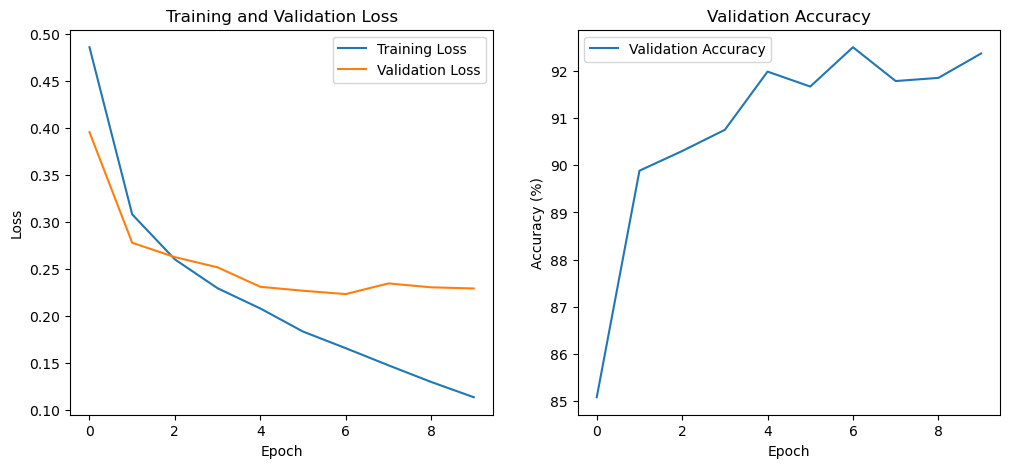

In [5]:
import matplotlib.pyplot as plt

# Move the model to GPU
model = CNNModel().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Lists to track training and validation loss
train_losses = []
val_losses = []
val_accuracies = []

# Training and Validation Loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


In [6]:
# Set the model to evaluation mode
model.eval()
correct, total = 0, 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print test accuracy
test_accuracy = 100 * correct / total
print(f'Accuracy on the test dataset: {test_accuracy:.2f}%')



Accuracy on the test dataset: 92.36%


Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.86      0.89      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.91      0.81      0.86      1000
       Dress       0.94      0.93      0.94      1000
        Coat       0.83      0.93      0.88      1000
      Sandal       1.00      0.98      0.99      1000
       Shirt       0.79      0.76      0.78      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



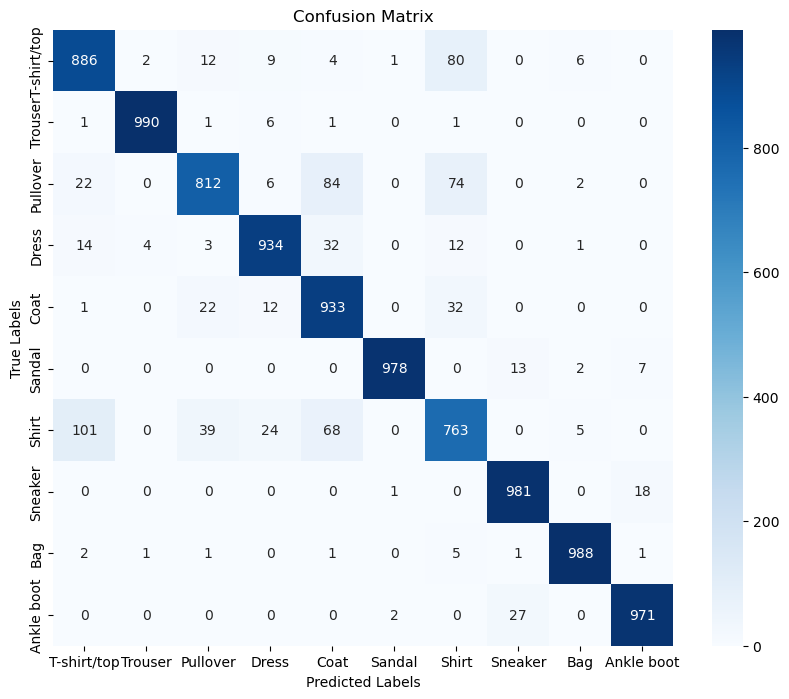

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
])
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
], yticklabels=[
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()